# 1. Prepare data

## 1.1 Import dependencies

In [1]:
# import libs
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

## 1.2 Create folder structures

In [3]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join("data", 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [4]:
# # Make the directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

# 2. Collect Possitives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [5]:
%cd /content/drive/MyDrive/Projects/Facial recognition

/content/drive/MyDrive/Projects/Facial recognition


In [6]:
# !wget http://vis-www.cs.umass.edu/lfw/lfw.tgz --directory ./data

In [7]:
# !tar -xf ./data/lfw.tgz

In [8]:
# %cd data

In [9]:
# for directory in os.listdir('lfw'):
#   for file in os.listdir(os.path.join('lfw', directory)):
#     EX_PATH = os.path.join('lfw', directory, file)
#     NEW_PATH = os.path.join(NEG_PATH, file)
#     os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [10]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[420:670, 970:1220, :]
    
    #Show image back to screen
    
    cv2.imshow('Image collection', frame)
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imagename = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imagename, frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imagename = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imagename, frame)

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
cv2.destroyAllWindows()

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [11]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [12]:
dir_test = anchor.as_numpy_iterator()

In [13]:
dir_test.next()

b'data/anchor/b4b6c084-363e-11ed-a66a-060f1abb7208.jpg'

## 3.2 Preprocessing - Scale and Resize

In [14]:
def preprocess(file_path):

  # Read in image from file path
  byte_img = tf.io.read_file(file_path)
  #Load in the image
  img = tf.io.decode_jpeg(byte_img)

  # Preprocessing steps - resizing the image to be 100x100x3
  img = tf.image.resize(img, (100, 100))
  img = img / 255.0

  return img

In [15]:
img = preprocess('data/anchor/b88996be-363e-11ed-a66a-060f1abb7208.jpg')

In [16]:
img.numpy().max()

0.6480392

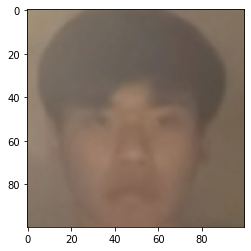

In [17]:
plt.imshow(img)

## 3.3 Create Labelled Dataset

` (anchor, positive) => 1, 1, 1, 1`

` (anchor, negative) => 0, 0, 0, 0`

In [18]:
positive

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [19]:
negative

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [20]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [21]:
samples = data.as_numpy_iterator()

In [22]:
example = samples.next()
example

(b'data/anchor/5433c40c-3899-11ed-b257-060f1abb7208.jpg',
 b'data/positive/5004d4de-3899-11ed-b257-060f1abb7208.jpg',
 1.0)

## 3.4 Build train and test partition

In [23]:
def preprocess_twin(input_img, validation_img, label):
  return (preprocess(input_img), preprocess(validation_img), label)

In [24]:
res = preprocess_twin(*example)
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.39607844, 0.34509805, 0.3137255 ],
         [0.39607844, 0.34509805, 0.3127451 ],
         [0.39313725, 0.34215686, 0.30686274],
         ...,
         [0.5264706 , 0.4715686 , 0.36568627],
         [0.5264706 , 0.4715686 , 0.36568627],
         [0.52843136, 0.4735294 , 0.36764705]],
 
        [[0.39681372, 0.34583333, 0.31446078],
         [0.39681372, 0.34583333, 0.3134804 ],
         [0.39607844, 0.34509805, 0.30980393],
         ...,
         [0.5235294 , 0.47058824, 0.36568627],
         [0.5203431 , 0.46740195, 0.3625    ],
         [0.52254903, 0.46960783, 0.3647059 ]],
 
        [[0.3990196 , 0.3480392 , 0.31666666],
         [0.3990196 , 0.3480392 , 0.3156863 ],
         [0.39313725, 0.34215686, 0.30686274],
         ...,
         [0.5137255 , 0.46666667, 0.3647059 ],
         [0.5144608 , 0.46740195, 0.36544117],
         [0.51666665, 0.46960783, 0.36764705]],
 
        ...,
 
        [[0.5615196 , 0.52230394

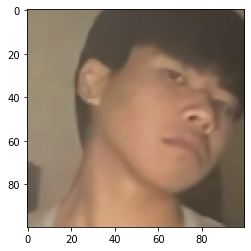

In [25]:
plt.imshow(res[1])

In [26]:
res[2]

1.0

In [27]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [28]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [29]:
samples = data.as_numpy_iterator()
samp = samples.next()

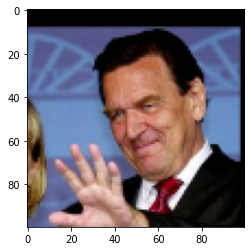

In [30]:
plt.imshow(samp[1])

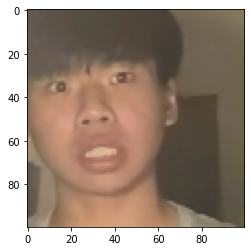

In [31]:
plt.imshow(samp[0])

In [32]:
# Train test split

##### Train. ####
train_data = data.take(round(len(data) * .7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [33]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [34]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()

In [35]:
len(train_sample[0])

16

In [36]:
#### Test #######
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [37]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

# 4. Model Engineering

## 4.1 Build Embedding layer

In [38]:
def make_embedding():
  inp = Input(shape = (100, 100, 3), name = 'input_image')

  # First block
  c1 = Conv2D(64, (10, 10), activation = 'relu')(inp)
  m1 = MaxPooling2D((2, 2))(c1)

  #Second block
  c2 = Conv2D(128, (7, 7), activation = 'relu')(m1)
  m2 = MaxPooling2D(64, (2, 2), padding = 'same')(c2)

  #Third block
  c3 = Conv2D(128, (4, 4), activation = 'relu')(m2)
  m3 = MaxPooling2D(64, (2, 2), padding = 'same')(c3)

  # Final embedding block
  c4 = Conv2D(256, (4, 4), activation = 'relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation = 'sigmoid')(f1)

  return Model(inputs = [inp], outputs = [d1], name = 'embedding')

In [39]:
model = make_embedding()
model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 39, 39, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build distance layer

In [40]:
# Siamese L1 Distance class
class L1Dist(Layer):
  # Init method - inheritance
  def __init__(self, **kwargs):
    super().__init__()

  def call(self, input_embedding, validation_embedding):
    return tf.math.abs(input_embedding - validation_embedding)

In [41]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [42]:
embedding = make_embedding()

In [43]:
def make_siamese_model():

  # Anchor image input in the network
  input_image = Input(name = 'input_img', shape = (100, 100, 3))

  # Validation image in the network
  validation_image = Input(name = 'validation_img', shape = (100, 100, 3))

  # Combine simasese distance components
  siamese_layer = L1Dist()
  siamese_layer._name = 'distance'
  distances = siamese_layer(embedding(input_image), embedding(validation_image))

  # Classification layer
  classifier = Dense(1, activation = 'sigmoid')(distances)

  return Model(inputs = [input_image, validation_image], outputs = classifier, name = "SiameseNetwork")

In [44]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [45]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [46]:
opt = tf.keras.optimizers.Adam(1e-4)

## 5.2 Establish Checkpoints

In [47]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

In [48]:
# os.mkdir(checkpoint_dir)

## 5.3 Build Train Step Function

In [49]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()

In [50]:
batch_1[0]

array([[[[0.6627451 , 0.59607846, 0.53333336],
         [0.66740197, 0.59289217, 0.5262255 ],
         [0.6698529 , 0.5982843 , 0.5227941 ],
         ...,
         [0.5257353 , 0.45906863, 0.3884804 ],
         [0.5264706 , 0.4598039 , 0.38921568],
         [0.5254902 , 0.45882353, 0.39607844]],

        [[0.66568625, 0.5990196 , 0.5362745 ],
         [0.67156863, 0.59705883, 0.53039217],
         [0.6745098 , 0.60294116, 0.527451  ],
         ...,
         [0.5252451 , 0.45857844, 0.3879902 ],
         [0.5245098 , 0.45784312, 0.3872549 ],
         [0.52254903, 0.45588234, 0.3852941 ]],

        [[0.66887254, 0.6022059 , 0.5394608 ],
         [0.6737745 , 0.5992647 , 0.532598  ],
         [0.6737745 , 0.6022059 , 0.5267157 ],
         ...,
         [0.52230394, 0.45563725, 0.38504902],
         [0.5252451 , 0.45857844, 0.3879902 ],
         [0.52843136, 0.4617647 , 0.39117646]],

        ...,

        [[0.54044116, 0.47377452, 0.4110294 ],
         [0.5382353 , 0.4715686 , 0.40882352]

In [51]:
@tf.function
def train_step(batch):

  # Record all of operations
  with tf.GradientTape() as tape:
    # Get anchor and positive/negative
    X = batch[:2]
    # get label
    y = batch[2]

    # Forward pass
    yhat = siamese_model(X, training = True)

    # Calculate loss
    loss = binary_cross_loss(y, yhat)
# Calculate gradients
  grad = tape.gradient(loss, siamese_model.trainable_variables)

# Calculate updated weights and apply to siamese model
  opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

  return loss

## 5.4 Build Training Loop

In [52]:
def train(data, EPOCHS):
  # Loop through epochs
  for epoch in range(1, EPOCHS + 1):
    print("\n Epoch {}/{}".format(epoch, EPOCHS))
    progbar = tf.keras.utils.Progbar(len(data))

  # Loop through batch
    for idx, batch in enumerate(data):
    # Run train step here
      train_step(batch)
      progbar.update(idx + 1)
    
    # Save checkpoints
    if epoch % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)


## 5.5 Train the model

In [53]:
EPOCHS = 50

In [54]:
train(train_data, EPOCHS)


 Epoch 1/50
21/21 [==============================] - 15s 114ms/step

 Epoch 2/50
21/21 [==============================] - 2s 89ms/step

 Epoch 3/50
21/21 [==============================] - 2s 89ms/step

 Epoch 4/50
21/21 [==============================] - 2s 90ms/step

 Epoch 5/50
21/21 [==============================] - 2s 90ms/step

 Epoch 6/50
21/21 [==============================] - 2s 90ms/step

 Epoch 7/50
21/21 [==============================] - 2s 91ms/step

 Epoch 8/50
21/21 [==============================] - 2s 91ms/step

 Epoch 9/50
21/21 [==============================] - 2s 90ms/step

 Epoch 10/50
21/21 [==============================] - 2s 93ms/step

 Epoch 11/50
21/21 [==============================] - 2s 97ms/step

 Epoch 12/50
21/21 [==============================] - 2s 92ms/step

 Epoch 13/50
21/21 [==============================] - 2s 92ms/step

 Epoch 14/50
21/21 [==============================] - 2s 94ms/step

 Epoch 15/50
21/21 [==============================] - 

# 6. Evaluate model

## 6.1 Import metrics

In [55]:
# Import metric calculation
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make predictions

In [56]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [57]:
# Make prediction
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[1.1860450e-06],
       [1.0000000e+00],
       [9.3370403e-08],
       [1.9463805e-06],
       [5.6608642e-06],
       [9.9996257e-01],
       [5.0482161e-09],
       [9.9999535e-01],
       [9.9963820e-01],
       [5.5062519e-09],
       [9.9946004e-01],
       [9.3175387e-09],
       [1.1686755e-06],
       [2.7143417e-06],
       [1.1709281e-08],
       [9.9984014e-01]], dtype=float32)

In [58]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1]

In [59]:
y_true

array([0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.],
      dtype=float32)

## 6.3 Calculate metrics

In [60]:
m = Precision()
m.update_state(y_true, y_hat)

# Return recall result
m.result().numpy()

1.0

In [61]:
m = Recall()
m.update_state(y_true, y_hat)

# Return recall result
m.result().numpy()

1.0

## 6.4 Visualize the results

# 7. Save the model

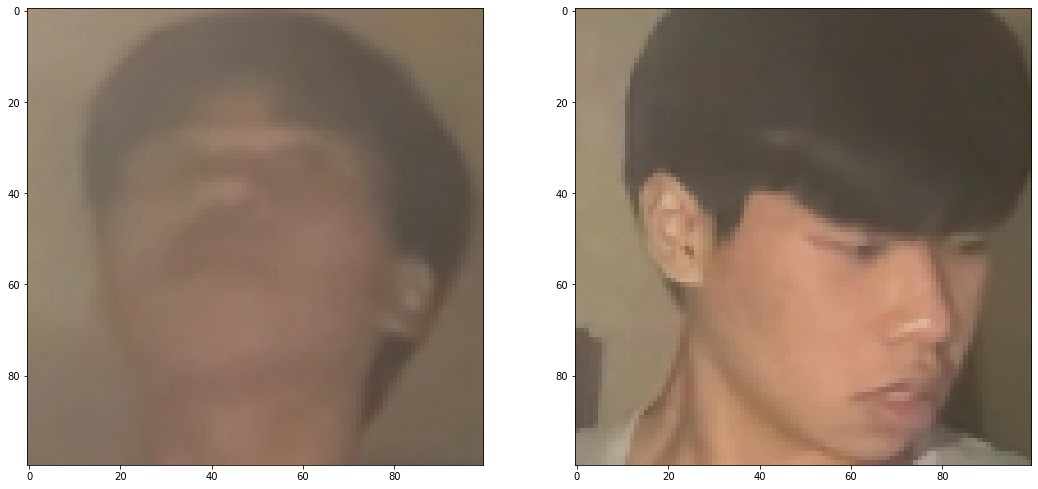

In [62]:

plt.figure(figsize = (18, 18))
plt.subplot(1, 2, 1)
plt.imshow(test_input[1])
plt.subplot(1, 2, 2)
plt.imshow(test_val[1])
plt.show()

# 7. Save model

In [63]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [64]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5',
                                  custom_objects = {'L1Dist': L1Dist, 'BinaryCrossEntropy': tf.losses.BinaryCrossentropy})

In [65]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real time test

## 8.1 Verification Function

In [68]:
def verify(model, detection_threshold, verification_threshold):
  # Build results array
  results = []
  for image in os.listdir(os.path.join(('application_data', 'verification_images'))):
    input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
    validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

    result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
    results.append(result)
  
  detection = np.sum(np.array(results) > detection_threshold)
  verification = np.sum(np.array() > detection_threshold)
  verfication = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
  verified = verification > verification_threshold

  return results, verified

## 8.2 OpenCV Real Time Verification

In [69]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[420:670, 970:1220, :]
    
    #Show image back to screen
    
    cv2.imshow('Image collection', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
      #Save input imahe to application input_image folder
      cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)

      # Run verification
      results, verified = verify(model, 0.5, 0.5)

    if cv2.waitKey(10) & 0xFF == ord('q'):
      break
cap.release()
cv2.destroyAllWindows()